In [ ]:
# # Для работы в колабе раскоменьте эти строки
# !git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
# %cd DeepGenerativeModels/

# Этап 1. Загрузка данных
В данном задании вам предстоит работать с уже знакомым датасетом с лицами и генерировать новые лица с заданными аттрибутами

In [1]:
import sys; sys.path.append('../../utils/')
from datasets.celeba import CelebADataset
import torch
import torch.nn.functional as F
from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange


## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch()

# args.num_domains = ??? # Задайте число доменов

# Spatial size of training images, images are resized to this size.
args.img_size = 256

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])
])
# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform)

# args.num_domains = 2*len(dataset.header)
args.num_domains = len(dataset.header)

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

## Визуализация датасетов

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

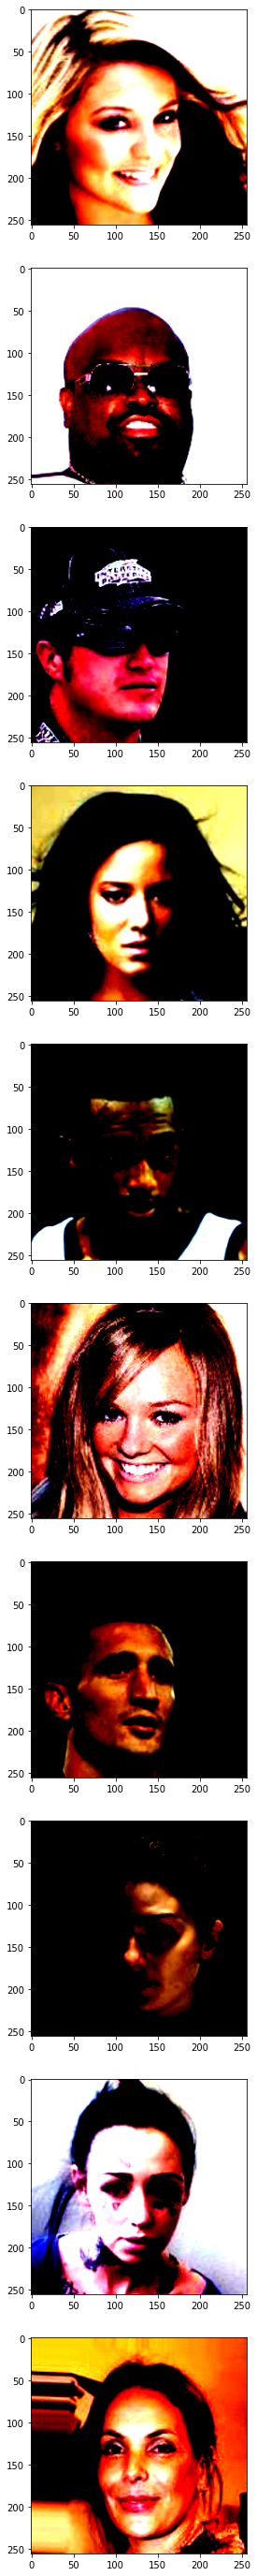

In [2]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    attributes = {k:v for k,v in zip(dataset.header, target['attributes'].detach().cpu().numpy())}
    plt.subplot(images_cnt,1,i+1)
    plt.imshow(img.detach().cpu().numpy().transpose(1,2,0))

# Этап 2. Обучение модели
В рамках данного задания предлагается реализовать и обучить StarGAN для генережки лиц с заданными аттрибутами
![](assets/stargan.png)

Вам на выбор предлагается реализовать [StarGANv1](https://arxiv.org/pdf/1711.09020.pdf) (**до 4 баллов**) или [StarGANv2](https://arxiv.org/abs/1912.01865) (**до 7 баллов**)

In [ ]:
# nets = Munch()
# nets.generator = ???
# nets.mapping_network = ???
# nets.style_encoder = ???
# nets.discriminator = ???

# Evaluation

In [ ]:
lpips = LPIPS()

In [29]:
from tqdm.auto import trange
test_iters = 100
values = []
for i in trange(test_iters):
    # fetch images and labels
    x_real, _ = next(iter(dataloader))
    x_ref, _ = next(iter(dataloader))
    x_ref2, _ = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    y_org = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # ваш домен
    
    x_real, x_ref, x_ref2 = [x.to(device).float() for x in [x_real, x_ref, x_ref2]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    x_fake = ??? # YOUR CODE IS HERE

    values.append(lpips(x_fake.cpu(), x_real.cpu()).squeeze().item())

assert(np.mean(values) < 1.3)

In [30]:
np.mean(values)

0.6601867008209229

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


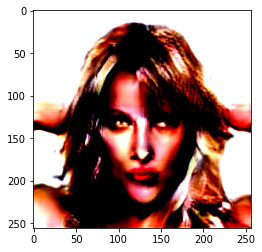

In [34]:
with torch.no_grad():
    z_trg = torch.randn((batch_size, args.latent_dim)).to(device)
    s_trg = nets.mapping_network(z_trg, y_trg)
#     s_trg = nets.style_encoder(x_ref2, y_trg)
    x_fake = nets.generator(x_real, s_trg)
plt.imshow(x_fake[1].permute(1,2,0).detach().cpu().numpy())

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**